In [3]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn

import ML_Models.data_loader as loader
plt.rcParams.update({'font.size': 36})
plt.rc('font', family='sans-serif')
plt.rcParams["axes.grid"] = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
device

device(type='cpu')

In [5]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

# data_name = "compas"
data_name = "adult"
# data_name = "german"

compas_dict = {
        "data_path": '../Data_Sets/COMPAS/',
        "filename_train": 'compas-train.csv',
        "filename_test": 'compas-test.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": 1235
    }

german_dict = {
        "data_path": '../Data_Sets/German_Credit_Data/',
        "filename_train": 'german-train.csv',
        "filename_test": 'german-test.csv',
        "label": "credit-risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
        "activFun": nn.Softplus(),
        "n_starting_instances": 200
    
    }

adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train-chg.csv',
        "filename_test": 'adult-test-chg.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 26,
        "H2": 52,
        "activFun": nn.Softplus(),
        "n_starting_instances": 9045
    }


data_meta_dictionaries = {
        "compas": compas_dict, 
        "adult": adult_dict, 
        "german":german_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"], scale = "standard")
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"], scale = "standard")


column_names = pd.read_csv(data_meta_info["data_path"] + data_meta_info["filename_train"]).drop(data_meta_info["label"], axis=1).columns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
# Data loader

train_loader = DataLoader(dataset_train, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 32, shuffle=False)

data = [i for i in train_loader]
num_feats = len(data[0][0][0])



In [7]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_feats

6

In [8]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [9]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X,y = X.to(device).float(), y.to(device).long()
        yp = model(X)
        
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, epsilon, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X,y = X.to(device).float(), y.to(device).long()
        delta = attack(model, X, y, epsilon, **kwargs)
        yp = model(X+delta)
        # print(yp,y)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)



In [10]:
## Baseline Neural Model 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epsilons = [0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

def train_robust_model(epsilon, num_epochs, path_to_store_model):
    model_robust = nn.Sequential(nn.Linear(num_feats,num_feats*2), nn.ReLU(), 
                      nn.Linear(num_feats*2,num_feats*4), nn.ReLU(), 
                      nn.Linear(num_feats*4,2)).to(device)
    
    opt = optim.SGD(model_robust.parameters(), lr=1e-2)
    
    print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Acc", "Rob. Test Loss", sep="\t")
    for i in range(num_epochs):
        train_err, train_loss = epoch_adversarial(train_loader, model_robust, fgsm, epsilon, opt)
        test_err, test_loss = epoch_adversarial(test_loader, model_robust, fgsm, epsilon)
        print(*("{:.6f}".format(i) for i in (train_err, train_loss, 1-test_err, test_loss)), sep="\t")  
    
    torch.save(model_robust, path_to_store_model)
    

# num_epochs = 10
# for epsilon in epsilons:
#     train_robust_model(epsilon, num_epochs, "./models/{}_nn_model_robust_eps_{}_chg.pth".format(data_name, epsilon) )

  

In [11]:
# Recourse Method 2
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 10, p_norm: int = 2,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold
        

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        self.classifier.eval()
        instance_label = 1 - target_class
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)

        while True:
            count = count + counter_step
            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = -1
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)
            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()
            

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, ord=self.p_norm, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
            y_logit_sum = np.sum([i for i in self.classifier(torch.from_numpy(x_ce).float()).detach().squeeze().numpy().tolist()[0]])
            y_candidate = torch.stack([torch.tensor(i) for i in self.classifier(torch.from_numpy(x_ce).float()).max(dim=1)[1].detach().numpy()])
            

            indeces_total = np.where(y_candidate != instance_label)
            indeces = indeces_total[0]
            if len(indeces) > 0:
                pass
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]
            
            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = candidate_dist[min_index] 
                break

        return torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star), count    
    

In [12]:
 
import torch
import numpy as np
from torch import nn
import datetime


class SCFE:
    
    def __init__(self, classifier, target_threshold: float = 0, _lambda: float = 10.0,
                 lr: float = 0.1, max_iter: int = 500, t_max_min: float = 0.5,
                 step: float = 0.10, norm: int = 1, optimizer: str = 'adam'):
        
        super().__init__()
        self.model_classification = classifier
        self.lr = lr
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.t_max_min = t_max_min
        self.norm = norm
        self.sigmoid = nn.Sigmoid()
        self.target_thres = target_threshold
        self._lambda = _lambda
        self.step = step
    
    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
            query instance: the point to be explained
            target_class: Direction of the desired change. If target_class = 1, we aim to improve the score,
                if target_class = 0, we aim to decrese it (in classification and regression problems).
            _lambda: Lambda parameter (distance regularization) parameter of the problem
        """
        
        if target_class == 1:
            target_prediction = torch.tensor([1]) #.float()
        else:
            target_prediction = torch.tensor([0]) #.float()
        
        output = self._call_model(query_instance)
        cf = query_instance.clone().requires_grad_(True)
        
        if self.optimizer == 'adam':
            optim = torch.optim.Adam([cf], self.lr)
        else:
            optim = torch.optim.RMSprop([cf], self.lr)
        
        # Timer
        t0 = datetime.datetime.now()
        t_max = datetime.timedelta(minutes=self.t_max_min)
        
        counterfactuals = []
        num_iterations_output = 0
        while not self._check_cf_valid(output, target_class):
            iter = 0
            distances = []
            all_loss = []
            while not self._check_cf_valid(output, target_class) and iter < self.max_iter:
                cf.requires_grad = True
                total_loss, loss_distance = self.compute_loss(self._lambda, cf,
                                                              query_instance,
                                                              target_prediction)
                optim.zero_grad()
                total_loss.backward(retain_graph=True)
                optim.step()
                
                output = self._call_model(cf)
                
                if self._check_cf_valid(output, target_class):
                    counterfactuals.append(cf.detach())
                    distances.append(loss_distance.clone().detach())
                    all_loss.append(total_loss.detach())
                
                iter = iter + 1
            num_iterations_output = iter
            if datetime.datetime.now() - t0 > t_max:
                break

            if self.step == 0.0:  # Don't search over lambdas
                break
            else:
                self._lambda -= self.step

        if not len(counterfactuals):
            print('No CE found')
            return torch.tensor(-1.0)
            
        
        # Choose the nearest counterfactual
        counterfactuals = torch.stack(counterfactuals)
        distances = torch.stack(distances)
        distances = distances.detach()
        index = torch.argmin(distances)
        counterfactuals = counterfactuals.detach()

        ce_star = counterfactuals[index]
        distance_star = distances[index]
        
        return ce_star.squeeze(), distance_star, num_iterations_output

    
    def compute_loss(self, _lambda: float, cf_candidate: torch.tensor, original_instance: torch.tensor,
                     target: torch.tensor) -> torch.tensor:
        output = self._call_model(cf_candidate)
        # classification loss
        ce_loss = nn.CrossEntropyLoss()
        loss_classification = ce_loss(output, target)
        # distance loss
        loss_distance = torch.norm((cf_candidate - original_instance), self.norm)
        # full loss
        total_loss = loss_classification + _lambda * loss_distance
        return total_loss, loss_distance

    def _call_model(self, cf_candidate):
        output = self.model_classification(cf_candidate)
        return output

    def _check_cf_valid(self, output, target_class):
        """ Check if the output constitutes a sufficient CF-example.
            target_class = 1 in general means that we aim to improve the score,
            whereas for target_class = 0 we aim to decrese it.
        """
        if target_class == 1:
            check = output.max(dim=1)[1].item() == 1
            return check
        else:
            check = output.max(dim=1)[1].item() == 0
            return check
        
        

In [35]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# from carla import log


def hyper_sphere_coordindates(n_search_samples, instance, high, low, p_norm=1):

    # Implementation follows the Random Point Picking over a sphere
    # The algorithm's implementation follows: Pawelczyk, Broelemann & Kascneci (2020);
    # "Learning Counterfactual Explanations for Tabular Data" -- The Web Conference 2020 (WWW)
    # It ensures that points are sampled uniformly at random using insights from:
    # http://mathworld.wolfram.com/HyperspherePointPicking.html

    # This one implements the growing spheres method from
    # Thibaut Laugel et al (2018), "Comparison-based Inverse Classification for
    # Interpretability in Machine Learning" -- International Conference on Information Processing
    # and Management of Uncertainty in Knowledge-Based Systems (2018)

    """
    :param n_search_samples: int > 0
    :param instance: numpy input point array
    :param high: float>= 0, h>l; upper bound
    :param low: float>= 0, l<h; lower bound
    :param p: float>= 1; norm
    :return: candidate counterfactuals & distances
    """

    delta_instance = np.random.randn(n_search_samples, instance.shape[1])
    dist = np.random.rand(n_search_samples) * (high - low) + low  # length range [l, h)
    norm_p = LA.norm(delta_instance, ord=p_norm, axis=1)
    d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
    delta_instance = np.multiply(delta_instance, d_norm)
    candidate_counterfactuals = instance + delta_instance

    return candidate_counterfactuals, dist


def growing_spheres_search(
    instance,
    keys_mutable,
    keys_immutable,
    continuous_cols,
    binary_cols,
    feature_order,
    model,
    n_search_samples=200,
    p_norm=1,
    step=0.1,
    max_iter=40000,
):

    """
    :param instance: df
    :param step: float > 0; step_size for growing spheres
    :param n_search_samples: int > 0
    :param model: sklearn classifier object
    :param p_norm: float=>1; denotes the norm (classical: 1 or 2)
    :param max_iter: int > 0; maximum # iterations
    :param keys_mutable: list; list of input names we can search over
    :param keys_immutable: list; list of input names that may not be searched over
    :return:
    """  #

    # correct order of names
    keys_correct = feature_order
    # divide up keys
    keys_mutable_continuous = list(set(keys_mutable) - set(binary_cols))
    keys_mutable_binary = list(set(keys_mutable) - set(continuous_cols))

    instance_immutable_replicated = np.repeat(
        instance[keys_immutable].values.reshape(1, -1), n_search_samples, axis=0
    )
    instance_replicated = np.repeat(
        instance.values.reshape(1, -1), n_search_samples, axis=0
    )
    instance_mutable_replicated_continuous = np.repeat(
        instance[keys_mutable_continuous].values.reshape(1, -1),
        n_search_samples,
        axis=0,
    )


    # init step size for growing the sphere
    low = 0
    high = low + step

    # counter
    count = 0
    counter_step = 1


    instance_label = int(model(torch.from_numpy(instance.values)).max(dim=1)[1].item())

    counterfactuals_found = False
    candidate_counterfactual_star = np.empty(
        instance_replicated.shape[1],
    )
    candidate_counterfactual_star[:] = np.nan
    while not counterfactuals_found or count > max_iter:
        count = count + counter_step

        # STEP 1 -- SAMPLE POINTS on hyper sphere around instance
        candidate_counterfactuals_continuous, _ = hyper_sphere_coordindates(
            n_search_samples, instance_mutable_replicated_continuous, high, low, p_norm
        )

        # sample random points from Bernoulli distribution
        candidate_counterfactuals_binary = np.random.binomial(
            n=1, p=0.5, size=n_search_samples * len(keys_mutable_binary)
        ).reshape(n_search_samples, -1)

        # make sure inputs are in correct order
        candidate_counterfactuals = pd.DataFrame(
            np.c_[
                instance_immutable_replicated,
                candidate_counterfactuals_continuous,
                candidate_counterfactuals_binary,
            ]
        )
        candidate_counterfactuals.columns = (
            keys_immutable + keys_mutable_continuous + keys_mutable_binary
        )
        # enforce correct order
        candidate_counterfactuals = candidate_counterfactuals[keys_correct]

        # STEP 2 -- COMPUTE l_1 DISTANCES
        if p_norm == 1:
            distances = np.abs(
                (candidate_counterfactuals.values - instance_replicated)
            ).sum(axis=1)
        elif p_norm == 2:
            distances = np.square(
                (candidate_counterfactuals.values - instance_replicated)
            ).sum(axis=1)
        else:
            raise ValueError("Distance not defined yet")
        y_candidate = model(torch.from_numpy(candidate_counterfactuals.values).float()).max(dim=1)[1].detach().numpy() == 1
        

        indeces = np.where(y_candidate != instance_label)
        candidate_counterfactuals = candidate_counterfactuals.values[indeces]
        candidate_dist = distances[indeces]

        if len(candidate_dist) > 0:  # certain candidates generated
            min_index = np.argmin(candidate_dist)
            candidate_counterfactual_star = candidate_counterfactuals[min_index]
            counterfactuals_found = True

        # no candidate found & push search range outside
        low = high
        high = low + step
        
        if p_norm == 1:
                distances = np.abs((instance.values - candidate_counterfactual_star)).sum(axis=1)
        elif p_norm == 2:
                distances = LA.norm(instance.values - candidate_counterfactual_star, axis=1)

    return candidate_counterfactual_star, distances, count


In [52]:
# TODO : Add the code which has the counter-factual with base.

# Create data with index 
n_samples_in_batch = 1000 #data_meta_info["n_starting_instances"]
test_loader = DataLoader(dataset_test, batch_size = n_samples_in_batch, shuffle=False)
data_iter = iter(test_loader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.float()

test_inputs = [inputs[i] for i in range(len(inputs))]

cost_per_robust_model = dict()
explanation_methods = ["cchvae", "scfe", "gsm"]

    

def get_cfe_explantions(model_bb, epsilon, path_to_dump, cfe_method = "scfe"):
    model_bb.eval()
    
    if cfe_method == "cchvae":
        vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"
        input_size = dataset_train.get_number_of_features()
        vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

        data_meta_info["vae_path"] = vae_path + f"vae_{data_name}_chg.pt"
        vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
        cchvae = CCHVAE(classifier=model_bb, model_vae=vae_model, n_search_samples = 100, step=1.3, max_iter=20000, target_threshold=0, p_norm = 2)
    elif cfe_method == "scfe":
        scfe = SCFE(classifier=model_bb, lr=2e-1, _lambda=0.00, step=0.00, max_iter=100000, target_threshold=0, norm = 2)
    
    costs_cfe = []
    distances_cfe = []
    total_valid_cases = 0
    for i in range(len(test_inputs)):
        if model_bb(test_inputs[i].reshape(1, -1)).max(dim=1)[1].item() == 1:
            costs_cfe.append(None)
            continue

        if i%500 == 0 and i!= 0:
            print("Mean cost so far : ", np.mean(distances_cfe))            
            print("Gotten {} done...".format(i))
        
        if cfe_method == "cchvae":
            ctr_cfe, ctr_val, num_iterations_output  = cchvae.generate_counterfactuals(
                query_instance= test_inputs[i].reshape(1, -1),
                target_class= 1 )
            ctr_cfe = ctr_cfe.numpy().tolist()
            ctr_val = ctr_val.item()
        elif cfe_method == "scfe":
            ctr_cfe, ctr_val, num_iterations_output  = scfe.generate_counterfactuals(
                    query_instance=test_inputs[i].reshape(1, -1),
                    target_class=1)
            if ctr_val != -1:
                ctr_cfe = ctr_cfe.numpy().tolist()
                ctr_val = ctr_val.item()
        elif cfe_method == "gsm":
            instance = pd.DataFrame(test_inputs[i].unsqueeze(0).numpy(), columns = column_names)
            ctr_cfe, ctr_val, num_iterations_output = growing_spheres_search(instance = instance ,keys_mutable =column_names,  keys_immutable=[], 
                       continuous_cols= data_meta_info["continuous_feats"] ,binary_cols = data_meta_info["binary_feats"] , feature_order = column_names, model = model_bb, p_norm = 2)
            ctr_cfe = ctr_cfe.tolist()
            ctr_val = ctr_val.item()
              
        if ctr_val > 0:
            costs_cfe.append([ctr_cfe, ctr_val, num_iterations_output])
            distances_cfe.append(ctr_val)
            total_valid_cases += 1
        else:
            costs_cfe.append(None)
    
    print("Processed {} valid cases.".format(total_valid_cases))

    import pickle as pkl
    pkl.dump(costs_cfe, open(path_to_dump, "wb"))
    
    return costs_cfe
    


    

In [241]:

for explanation_method in ["scfe"]: #["cchvae"]:
    print("Explanation Method : {} processing...".format(explanation_method))
    cost_per_robust_model[explanation_method] = dict()
    for epsilon in epsilons:
        print("Processing...", epsilon)
        model_rob = torch.load("./models/{}_nn_model_robust_eps_{}_chg.pth".format(data_name, epsilon)).cpu()
        cost_per_robust_model[explanation_method][epsilon] = get_cfe_explantions(model_rob, epsilon, "./explanations/nn_{}_base_{}_standard_{}_label.pkl".format(data_name, explanation_method, epsilon) , cfe_method = explanation_method)
        

    
    
    

Explanation Method : scfe processing...
Processing... 0
Processed 351 valid cases.
Processing... 0.02
Processed 371 valid cases.
Processing... 0.05
Processed 400 valid cases.
Processing... 0.1
Processed 418 valid cases.
Processing... 0.15
Processed 441 valid cases.
Processing... 0.2
Processed 445 valid cases.
Processing... 0.25
Processed 456 valid cases.
Processing... 0.3
Processed 457 valid cases.


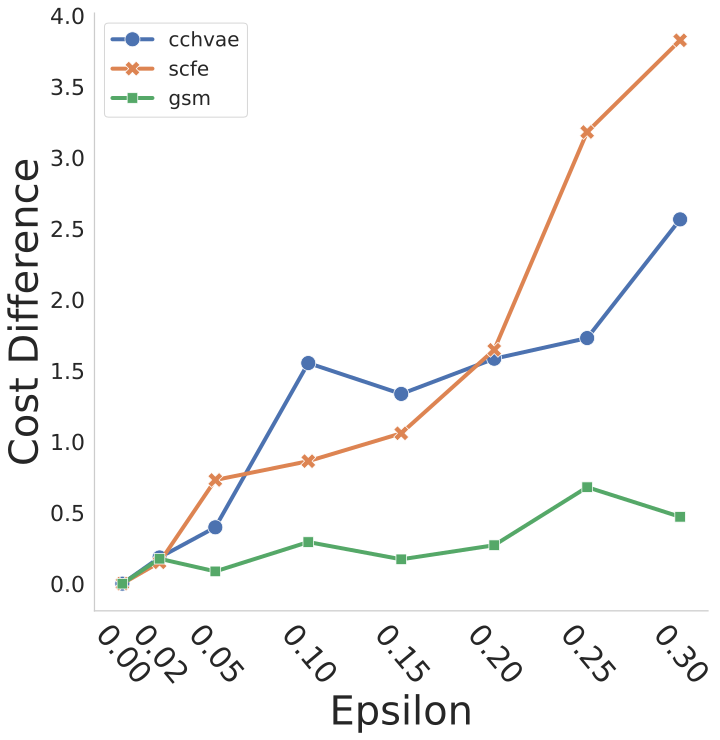

In [243]:
# Compute differences

import pickle as pkl
data_df_dict = pkl.load(open("cost_difference_dump_{}.pkl".format(data_name), "rb"))


df = pd.DataFrame(data_df_dict)

import seaborn
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Method"] = tidy["Variable"]
tidy["Cost Difference"] = tidy["Value"]

fig, ax1 = plt.subplots(figsize=(11, 11))
ax1.grid(False)
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Cost Difference", hue="Method" , style="Method", markers=True, dashes=False, linewidth = 4, markersize = 15)
p.set_xlabel("Epsilon", fontsize = 40)
p.set_ylabel("Cost Difference", fontsize = 40)
p.legend(labels=explanation_methods, fontsize = 20)
plt.xticks(epsilons, rotation = -50, fontsize = 30)
seaborn.despine(fig)
fig.savefig("plots/{}_nn_cost_difference.png".format(dataname), bbox_inches='tight')  



In [260]:
# Plot : Plot Validity baseline and robust models 

import pickle as pkl
data_df_dict = pkl.load(open("validity_dump_{}.pkl".format(data_name), "rb"))


Loading... 0
Loading... 0.02
Loading... 0.05
Loading... 0.1
Loading... 0.15
Loading... 0.2
Loading... 0.25
Loading... 0.3
Loading... 0
Loading... 0.02
Loading... 0.05
Loading... 0.1
Loading... 0.15
Loading... 0.2
Loading... 0.25
Loading... 0.3
Loading... 0
Loading... 0.02
Loading... 0.05
Loading... 0.1
Loading... 0.15
Loading... 0.2
Loading... 0.25
Loading... 0.3
cchvae
scfe
gsm


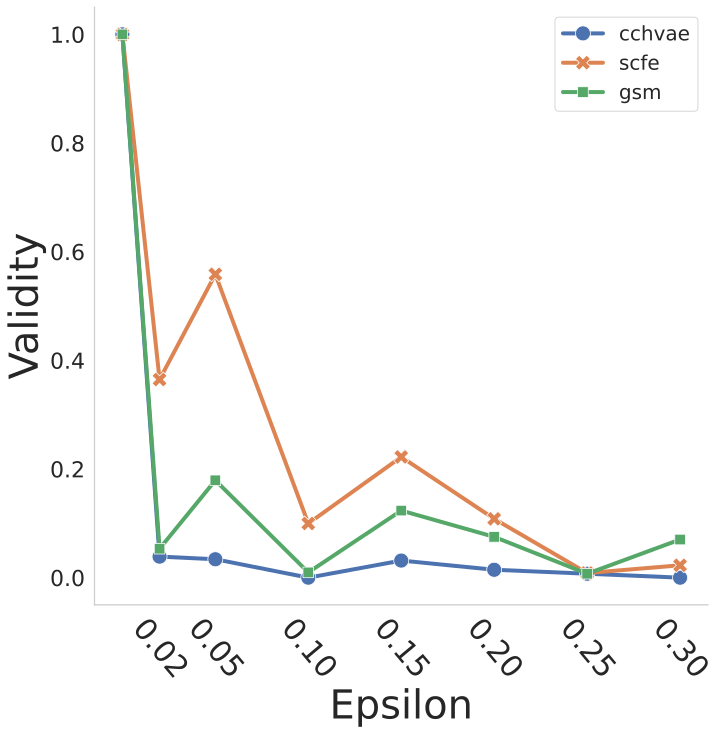

In [262]:
import seaborn
tidy = df.melt(id_vars='epsilon').rename(columns=str.title)
tidy["Method"] = tidy["Variable"]
tidy["Validity"] = tidy["Value"]

fig, ax1 = plt.subplots(figsize=(11, 11))
ax1.grid(False)
p= seaborn.lineplot(data=tidy, x="Epsilon", y="Validity", hue="Method" , style="Method", markers=True, dashes=False, linewidth = 4, markersize = 15)
p.set_xlabel("Epsilon", fontsize = 40)
p.set_ylabel("Validity", fontsize = 40)
p.legend(labels=explanation_methods, fontsize = 20)
plt.xticks(epsilons[1:], rotation = -50, fontsize = 30)
seaborn.despine(fig)
fig.savefig("plots/{}_validity.png".format(data_name), bbox_inches='tight')  



